## UNGA JSON

In [27]:
import json
import cohere
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

An array of strings for the model to embed. Maximum number of texts per call is 96. We recommend reducing the length of each text to be under 512 tokens for optimal quality - texts longer than 512 tokens will be spliced and the resulting embeddings of each component are then averaged and returned. The token limit per text is 4096, and the minimum is 1 token.

In [36]:
# Opening JSON file
f = open('docs.json', 'r', encoding='utf-8')
  
# returns JSON object as 
# a dictionary
data = json.load(f)
  
n = 1  
max_texts = 96 + 15 # 15 or so get dropped
max_tokens = 1024 # 512 throws error for most reports so moving to 1024

title_lst = []
id_lst = []
date_lst = []
body_lst = []
# Iterating through the json
# list
for i in data:
    if n > max_texts:
        break

    #print(i)
    response = i['response']

    if response['numFound'] > 0:
        docs = response['docs'][0]
    
        title = docs['title_en']
        print(title)
        id = docs['id']
        #print(id)
        date = docs['publicationDate']
        #print(date)
        body = docs['body_en']
        #print(body)

    # check body is not too long
    if len(body)//4 > max_tokens:
        print('too long')
        
    else:
        n += 1
        title_lst.append(title)
        id_lst.append(id)
        date_lst.append(date)
        body_lst.append(body)
  
# Closing file
f.close()

ASSISTANCE TO BOLIVIA AS A RESULT OF THE FLOODING EXPERIENCED IN RECENT MONTHS : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
THE DESTRUCTION OF RELICS AND MONUMENTS IN AFGHANISTAN : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
SECURITY COUNCIL RESOLUTION 1346 (2001) [ON EXTENSION OF THE MANDATE OF THE UN MISSION IN SIERRA LEONE (UNAMSIL)]
too long
SECURITY COUNCIL RESOLUTION 1340 (2001) [ON THE NOMINATIONS FOR PERMANENT JUDGES OF THE INTERNATIONAL TRIBUNAL FOR THE FORMER YUGOSLAVIA]
SECURITY COUNCIL RESOLUTION 1347 (2001) [ON ESTABLISHMENT OF THE LIST OF CANDIDATES NOMINATED FOR JUDGES OF THE INTERNATIONAL TRIBUNAL FOR RWANDA]
ORGANIZATIONAL ARRANGEMENTS FOR THE SPECIAL SESSION OF THE GENERAL ASSEMBLY ON HIV/AIDS AND ITS PREPARATORY PROCESS : RESOLUTION / ADOPTED BY THE GENERAL ASSEMBLY
too long
SECURITY COUNCIL RESOLUTION 1343 (2001) [ON THE SITUATION IN LIBERIA]
too long
CONDITIONS OF SERVICE AND COMPENSATION FOR THE AD LITEM JUDGES OF THE INTERNATIONAL TRIBUNAL FOR THE PROSECUTION 

In [37]:
print(len(body_lst))

96


In [24]:
api_key = ''
co = cohere.Client(api_key)

In [38]:
response = co.embed(body_lst)
#print('Embeddings: {}'.format(response.embeddings))

In [39]:
# start by just plotting first two indicies
x = []
y = []
for e in response.embeddings:
    x.append(e[0])
    y.append(e[1])

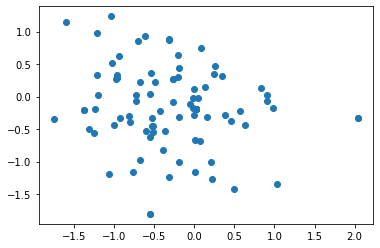

In [40]:
plt.plot(x,y,'o')

In [41]:
# save just x,y as df csv with rest of info
# (add proposed country?)
df = pd.DataFrame(list(zip(id_lst, date_lst, title_lst, x, y)),
               columns =['id', 'date', 'title', 'x', 'y'])
df.head(5)

,id,date,title,x,y
0,A/RES/55/241_en,2001-02-14T00:00:00Z,ASSISTANCE TO BOLIVIA AS A RESULT OF THE FLOOD...,-0.554541,-1.806201
1,A/RES/55/241_en,2001-02-14T00:00:00Z,ASSISTANCE TO BOLIVIA AS A RESULT OF THE FLOOD...,-0.554541,-1.806201
2,A/RES/55/243_en,2001-05-01T00:00:00Z,THE DESTRUCTION OF RELICS AND MONUMENTS IN AFG...,1.035698,-1.350670
3,S/RES/1340(2001)_en,2001-02-08T00:00:00Z,SECURITY COUNCIL RESOLUTION 1340 (2001) [ON TH...,-1.203976,0.026266
4,S/RES/1347(2001)_en,2001-03-30T00:00:00Z,SECURITY COUNCIL RESOLUTION 1347 (2001) [ON ES...,-0.971191,0.291992


In [42]:
df.to_csv('unga_embeddings_2d.csv', index=False) # not in csv form? dont want body

In [43]:
# now add classifications (can do on titles for examples, colour on this) and summaries in

In [48]:
# k means clustering
#X = response.embeddings
#kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
#print(kmeans)

In [49]:
X = response.embeddings

In [50]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components=2)
 
pca_features = pca.fit_transform(X)

In [51]:
X = np.array(X)

In [52]:
print('Shape before PCA: ', X.shape)
print('Shape after PCA: ', pca_features.shape)

Shape before PCA:  (96, 4096)
Shape after PCA:  (96, 2)


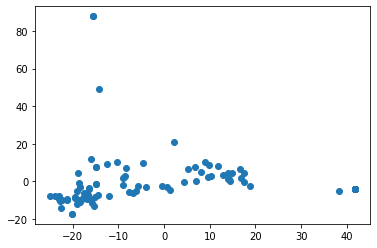

In [58]:
# plot those clusters
x = []
y = []
for e in pca_features:
    x.append(round(e[0],4))
    y.append(round(e[1],4))

plt.plot(x,y,'o')

In [61]:
# save just x,y as df csv with rest of info
# (add proposed country?)
df = pd.DataFrame(list(zip(id_lst, date_lst, title_lst, x, y)),
               columns =['id', 'date', 'title', 'x', 'y'])

# remove duplicates
df.drop_duplicates(subset=None, keep="first", inplace=True)
df.head(5)

,id,date,title,x,y
0,A/RES/55/241_en,2001-02-14T00:00:00Z,ASSISTANCE TO BOLIVIA AS A RESULT OF THE FLOOD...,-14.9105,7.5859
2,A/RES/55/243_en,2001-05-01T00:00:00Z,THE DESTRUCTION OF RELICS AND MONUMENTS IN AFG...,-4.5666,9.9064
3,S/RES/1340(2001)_en,2001-02-08T00:00:00Z,SECURITY COUNCIL RESOLUTION 1340 (2001) [ON TH...,9.0360,10.4300
4,S/RES/1347(2001)_en,2001-03-30T00:00:00Z,SECURITY COUNCIL RESOLUTION 1347 (2001) [ON ES...,9.8913,8.8376
5,A/RES/55/249_en,2001-05-01T00:00:00Z,CONDITIONS OF SERVICE AND COMPENSATION FOR THE...,-12.5225,9.0371


In [62]:
# put all in data frame and save as .csv
df.to_csv('unga_embeddings_pca.csv', index=False)

https://docs.cohere.ai/docs/semantic-search

In [ ]:
# semantic search on this text

In [ ]:
# topic modelling